In [126]:
import numpy as np
import pandas as pd

## Plot style

In [127]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams["figure.dpi"] = 150

import seaborn as sns
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

In [41]:
data = pd.read_parquet("../data/data.parquet")

# Load data table, perform merges, and select features 

In [129]:
df = pd.read_parquet("../data/data.parquet")

#Compute absolute G-magnitudes from Bailer-Jones distance estimates
df['MG'] = df['gaia_phot_g_mean_mag'] - 5 * (np.log10(df['gaia_r_est']) - 1)

#Assert errors of 0.1 mag for now
df['MG_err'] = 0.1*np.ones(len(df)) 
df['gaia_bp_rp_err'] = 0.1*np.ones(len(df))
df['bf18_e_[alpha/Fe]'] = 0.1*np.ones(len(df))
df['l20_e_Rvar'] = 100*np.ones(len(df))

#Santos et al. 2021
san = pd.read_csv("../data/S21_rotators.csv")
san = san.add_prefix('san_')

df = df.merge(san, how='left', left_on='kepid', right_on='san_KIC')
df = df.drop_duplicates(subset=['kepid'], keep='first')

print(len(df), 'stars after dropping duplicates')

#df['m13_Prot']
#df['m13_e_Prot']
#df['m13_Rvar']
#df['bf18_logRHK']
#df['bf18_Age']
#df['bf18_Age_maxerr']
#df['cks_age']
#df['cks_age_maxerr']
#df['b18_EW(Li)']
#df['b18_e_EW(Li)']
#df['b18_A(Li)']
#df['b18_e_A(Li)']
#Rvar, kinematics

obs_cols = []
err_cols = []
all_cols = []

# Select all of the Brewer & Fischer 2018 abundances (normalized to hydrogen)
# Exclude [M/H] (which is dependent on other abundances) and [N/H] (which is not reliably measured)

for col in df.columns:
    if ("bf18_[" in col) & ("/H]" in col) & (col!="bf18_[M/H]") & (col!="bf18_[N/H]"):
        obs_cols.append(col)
        all_cols.append(col)
    
    if ("bf18_e_[" in col) & ("/H]" in col) & (col!="bf18_e_[M/H]") & (col!="bf18_e_[N/H]"):
        err_cols.append(col)
        all_cols.append(col)

#Note. Including bf18_vsini led to high variance in the validation set (overfitting?).      
for col in ["p20_cks_slogg",
            "cks_age"]:

            obs_cols.append(col)
            all_cols.append(col)
            
# Right now the error columns are not being used.
# Note there are no errors for Rvar
for col in ["p20_cks_slogg_err1",
            "cks_age_maxerr"]:

            err_cols.append(col)
            all_cols.append(col)

print(len(obs_cols), 'columns')
print(len(err_cols), 'error columns')

#Drop NaNs
df = df.dropna(subset=all_cols) 
df_err = df[err_cols]
df = df[obs_cols]

print(len(df), 'stars in final data table')

8214 stars after dropping duplicates
16 columns
16 error columns
926 stars in final data table


## Check that there are no NaNs, missing values, or else perform imputation

In [130]:
df.isna().sum()

bf18_[C/H]       0
bf18_[O/H]       0
bf18_[Na/H]      0
bf18_[Mg/H]      0
bf18_[Al/H]      0
bf18_[Si/H]      0
bf18_[Ca/H]      0
bf18_[Ti/H]      0
bf18_[V/H]       0
bf18_[Cr/H]      0
bf18_[Mn/H]      0
bf18_[Fe/H]      0
bf18_[Ni/H]      0
bf18_[Y/H]       0
p20_cks_slogg    0
cks_age          0
dtype: int64

We have to guard against data leakage. Because each star is represented more than once (since a star can host more than one planet) we must double-check that there are no duplicates so that a star doesn't end up in both the training and validation sets. 

# Outlier pruning

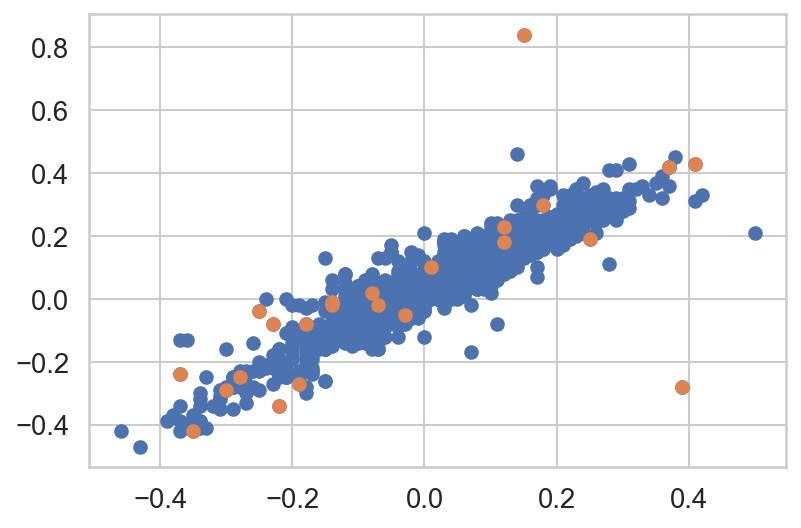

In [136]:
cols = df.columns
outliers = np.zeros(len(df), dtype=bool)

sigma_thresh = 4

for col in df.columns:
    outliers += abs(df[col] - np.mean(df[col])) / np.std(df[col]) > sigma_thresh

df_arr = np.array(df)

plt.scatter(df_arr[:,5], df_arr[:,6])
plt.scatter(df_arr[:,5][outliers], df_arr[:,6][outliers]);

# Prepare the data

In [151]:
Y = np.array(df[~outliers])
err = np.array(df_err[~outliers])

# Zero mean and normalize data (and errors) in each column
emp_mu = np.mean(Y, axis=0)
emp_sigma = np.std(Y, axis=0)
Y = (Y - emp_mu[None]) / emp_sigma[None]
err = err / emp_sigma[None]

# The weights are just the inverse variances
weights = 1.0 / err ** 2

# Zero out 10% of the weights as a validation
# Note: still using the star in the training. Zero-ing out elements, not rows.
validate_mask = np.random.default_rng(567).uniform(0, 1, weights.shape) < 0.1
weights[validate_mask] = 0.0

print("Shape of data matrix:", Y.shape)
print("Shape of error matrix:", err.shape)
print("Shape of weights:", weights.shape)

Shape of data matrix: (903, 16)
Shape of error matrix: (903, 16)
Shape of weights: (903, 16)


# What should the dimension of the latent space be? 

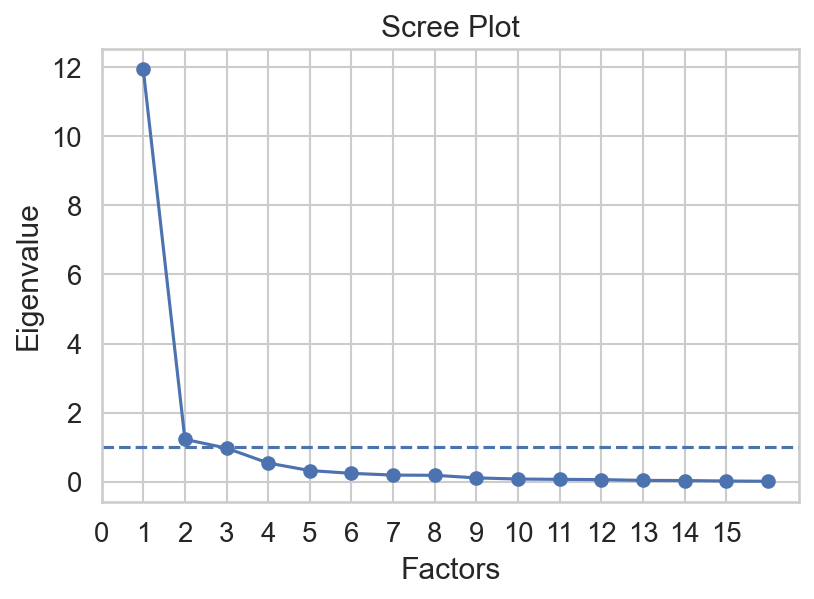

In [138]:
from factor_analyzer import FactorAnalyzer

# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer()
fa.fit(Y)
eigen_values, vectors = fa.get_eigenvalues()

plt.plot(range(1,Y.shape[1]+1), eigen_values, 'o-')
plt.xticks(range(Y.shape[1]))
plt.title('Scree Plot')
plt.axhline(1, ls='--')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue');

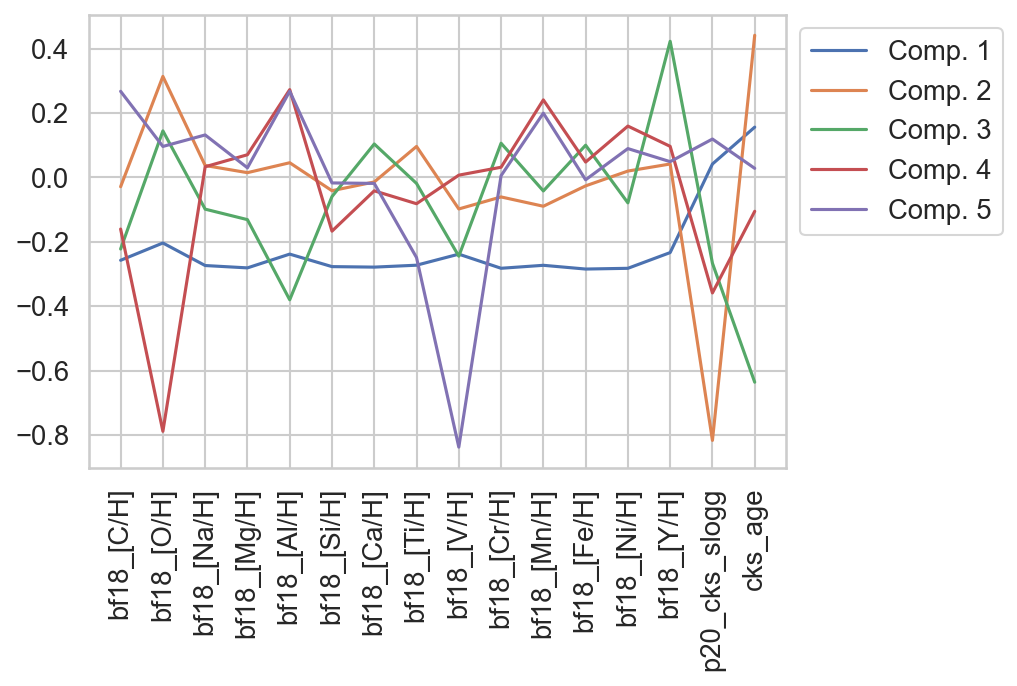

In [139]:
from sklearn.decomposition import FactorAnalysis,PCA

latent_dim = 5

pca = PCA(latent_dim).fit(Y)

for i in range(pca.n_components):
    plt.plot(pca.components_[i], label="Comp. "+f"{i+1}")
    
plt.xticks(np.arange(np.shape(Y)[1]), df.columns, rotation=90)
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

# Factor Analysis

In [140]:
#Can also do factor analysis
print(np.shape(pca.components_))
fa = FactorAnalysis(latent_dim, rotation="varimax").fit(Y)
print(np.shape(fa.components_))

(5, 16)
(5, 16)


/var/folders/q3/qrdpn9t13rq5m_6ndvm7n5580001hf/T/ipykernel_50949/1128998964.py:23: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/var/folders/q3/qrdpn9t13rq5m_6ndvm7n5580001hf/T/ipykernel_50949/1128998964.py:23: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/var/folders/q3/qrdpn9t13rq5m_6ndvm7n5580001hf/T/ipykernel_50949/1128998964.py:23: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


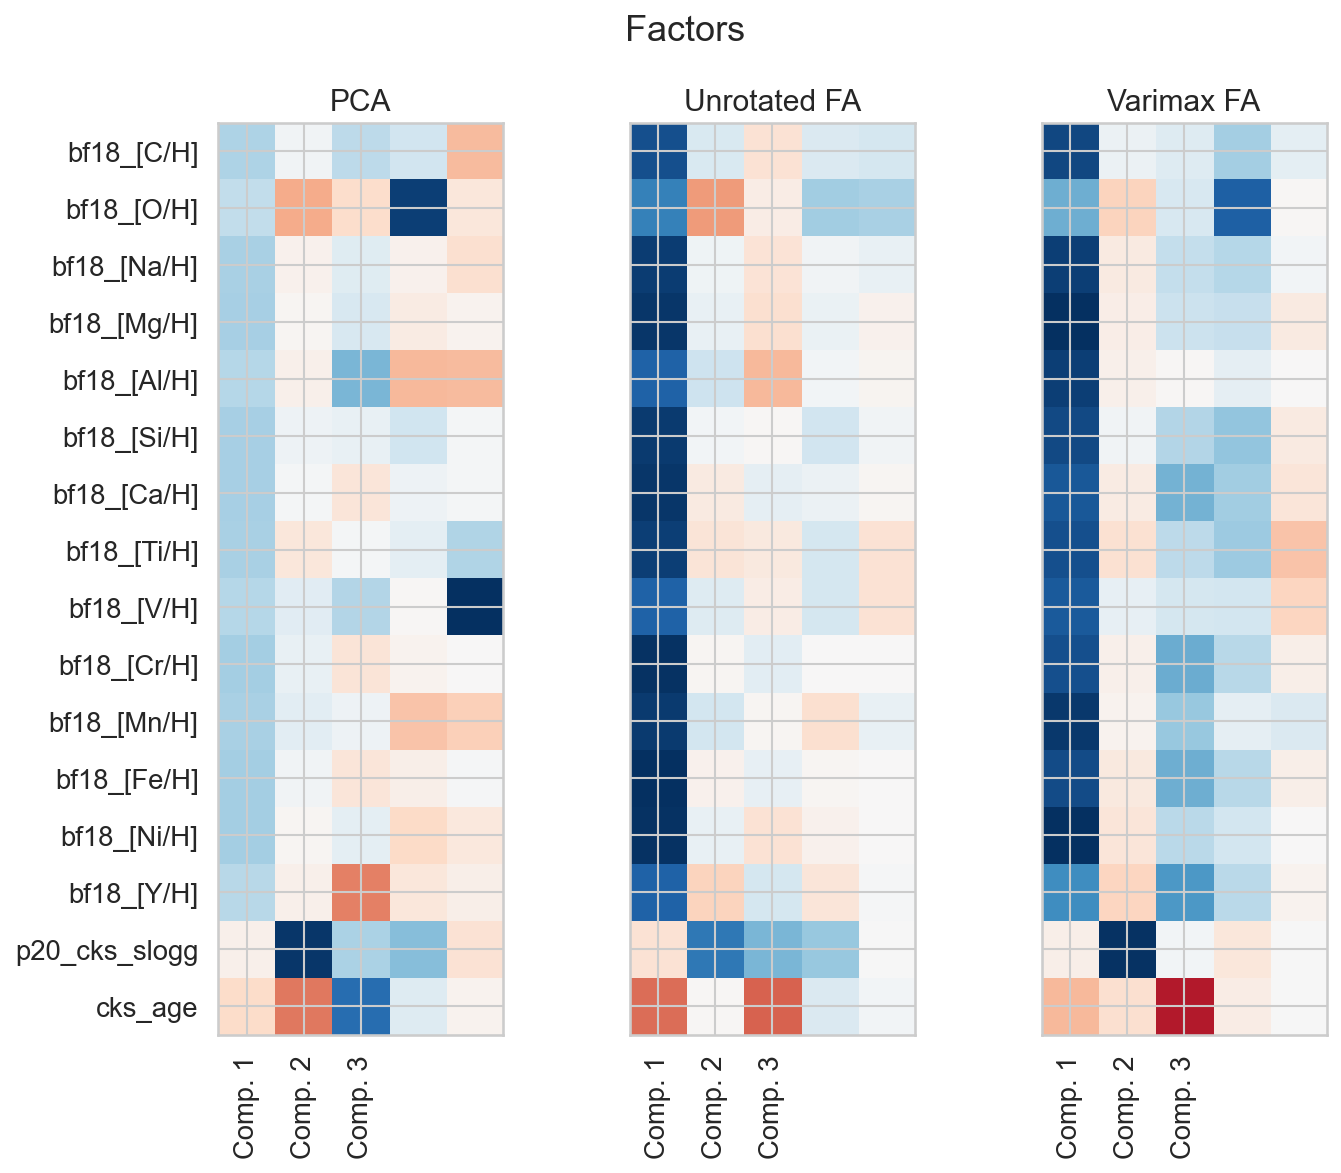

In [145]:
feature_names = list(df.columns)

methods = [
    ("PCA", PCA()),
    ("Unrotated FA", FactorAnalysis()),
    ("Varimax FA", FactorAnalysis(rotation="varimax")),
]

fig, axes = plt.subplots(ncols=len(methods), figsize=(10, 8))

for ax, (method, fa) in zip(axes, methods):
    fa.set_params(n_components=latent_dim)
    fa.fit(Y)
    
    components = fa.components_.T
    #print("\n\n %s :\n" % method)
    #print(np.shape(components))
    #print(components)

    vmax = np.abs(components).max()
    ax.imshow(components, cmap="RdBu_r", vmax=vmax, vmin=-vmax)
    ax.set_yticks(np.arange(len(feature_names)))
    if ax.is_first_col():
        ax.set_yticklabels(feature_names)
    else:
        ax.set_yticklabels([])
    ax.set_title(str(method))
    ax.set_xticks(np.arange(n_comps))    
    ax.set_xticklabels(["Comp. "+str(i+1) for i in range(3)], rotation=90)

fig.suptitle("Factors")
plt.tight_layout();

# The PCA model

In [154]:
import jax
import jax.numpy as jnp

jax.config.update("jax_enable_x64", True)

def model(params):
    return params["mean"][None] + params["U"] @ params["V"]

def loss(params, lam=1e-8):
    
    # Negative log likelihood
    nll = 0.5 * jnp.sum(jnp.square(Y - model(params)) * weights)
    
    # Regularization terms (presently assuming lambda coefficient is fixed for each term)
    reg = 0.5 * lam * jnp.sum(jnp.square(params["mean"]))
    reg += 0.5 * lam * jnp.sum(jnp.square(params["U"]))
    reg += 0.5 * lam * jnp.sum(jnp.square(params["V"]))
    
    return nll + reg

loss_grad_fn = jax.jit(jax.value_and_grad(loss))

params = {
    "mean": jnp.zeros(Y.shape[1]),
    "U": jnp.asarray(pca.transform(Y)),
    "V": jnp.asarray(pca.components_),
}

loss(params)

for key in params:
    print(key, params[key].shape)
#print(params["mean"].shape)

mean (16,)
U (903, 5)
V (5, 16)


# Training

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:02<00:00, 8243.86it/s]


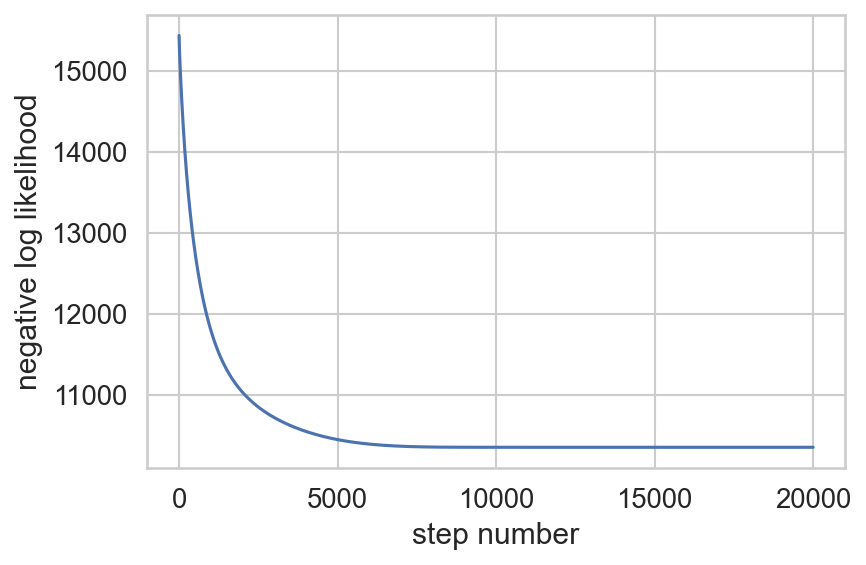

In [155]:
import optax
from tqdm import trange

learning_rate = 3e-4

tx = optax.adam(learning_rate=learning_rate)
opt_state = tx.init(params)

@jax.jit
def step(params, opt_state):
    loss_val, grads = loss_grad_fn(params)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return loss_val, params, opt_state

losses = []
for i in trange(20_000):
    loss_val, params, opt_state = step(params, opt_state)
    losses.append(loss_val)

plt.plot(losses)
plt.ylabel("negative log likelihood")
_ = plt.xlabel("step number")

# What do the measurements look like as a function of the latent variables?

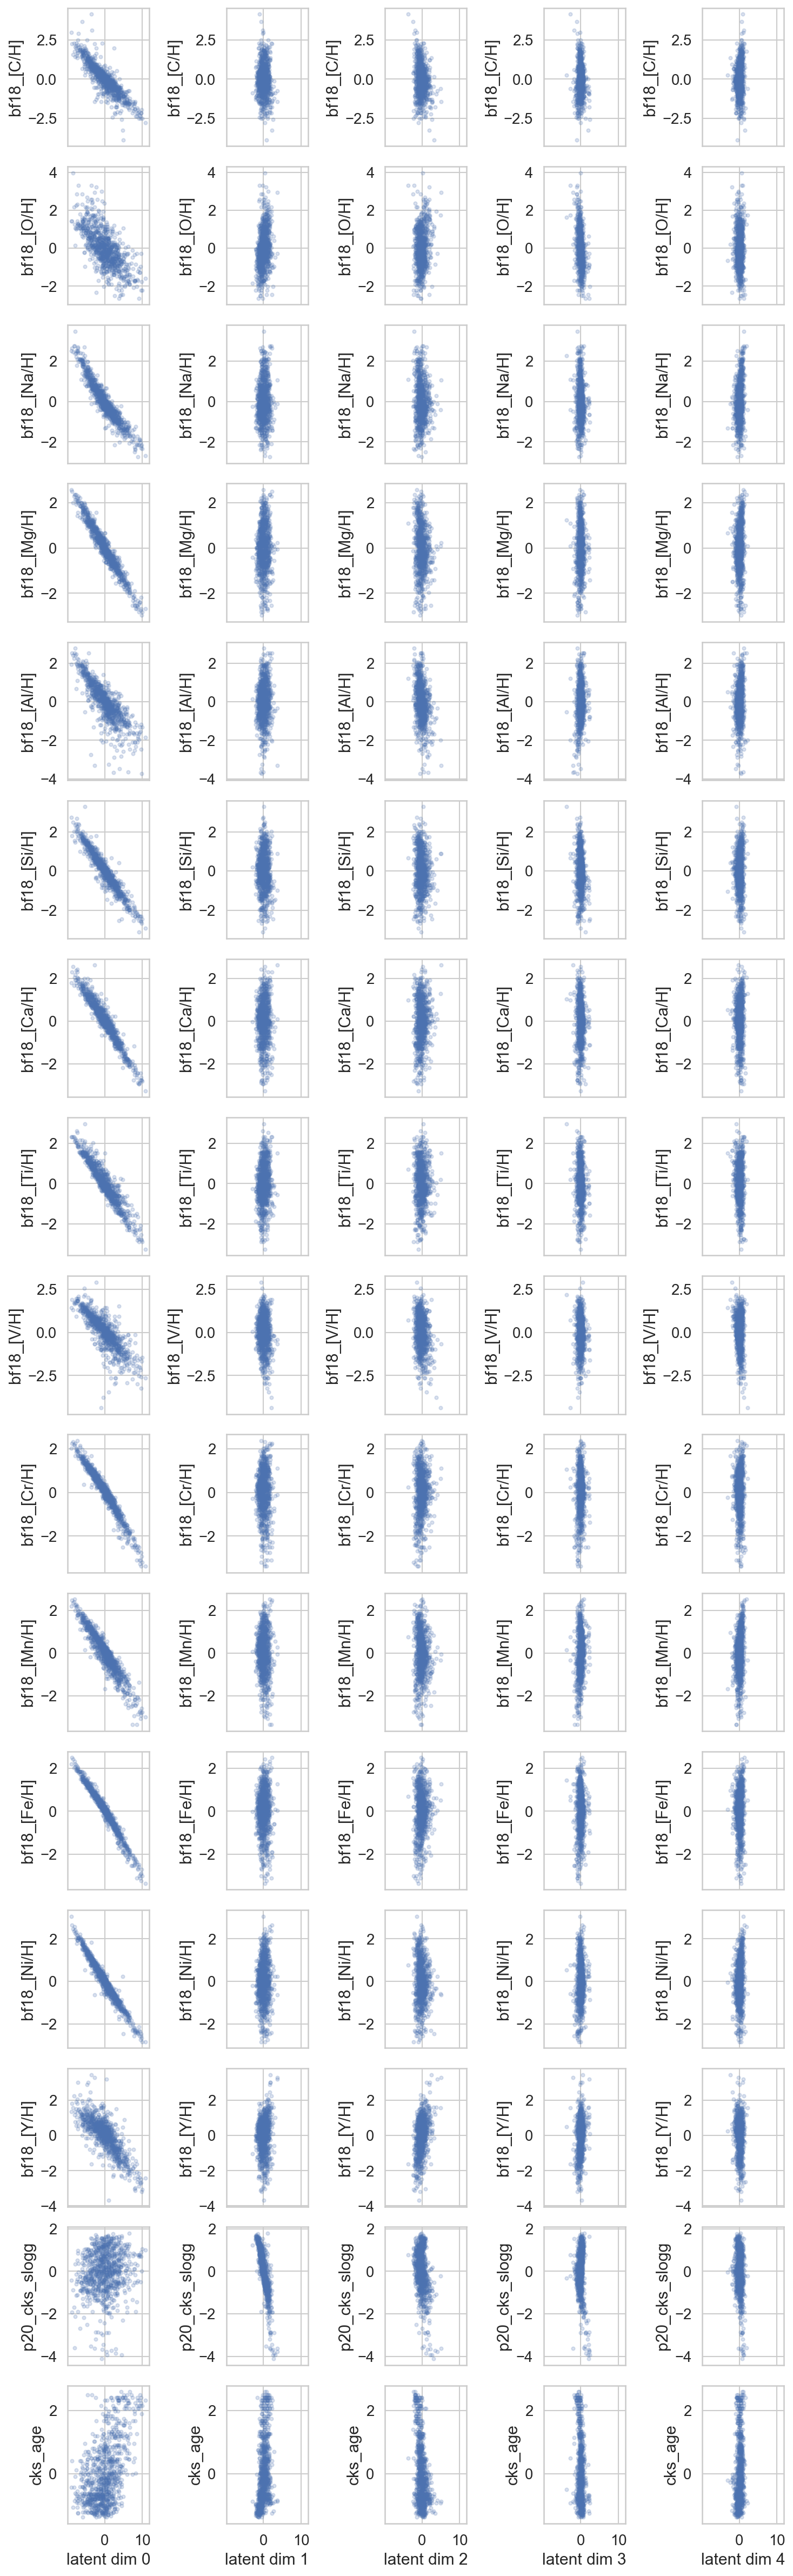

In [158]:
# What do the measurements look like as a function of the first latent dimension
fig, axes = plt.subplots(nrows=Y.shape[1], 
                         ncols=params["U"].shape[1],
                         sharex=True, figsize=(10, 32))


for j in range(params["U"].shape[1]):

    for i in range(Y.shape[1]):
    
        ax = axes[i,j]
        ax.plot(params["U"][:, j], Y[:, i], ".", alpha=0.2)
        ax.set_ylabel(df.columns[i])
        
    axes[-1,j].set_xlabel("latent dim "+str(j))
        

plt.tight_layout()

# How well does the model perform on held out data?

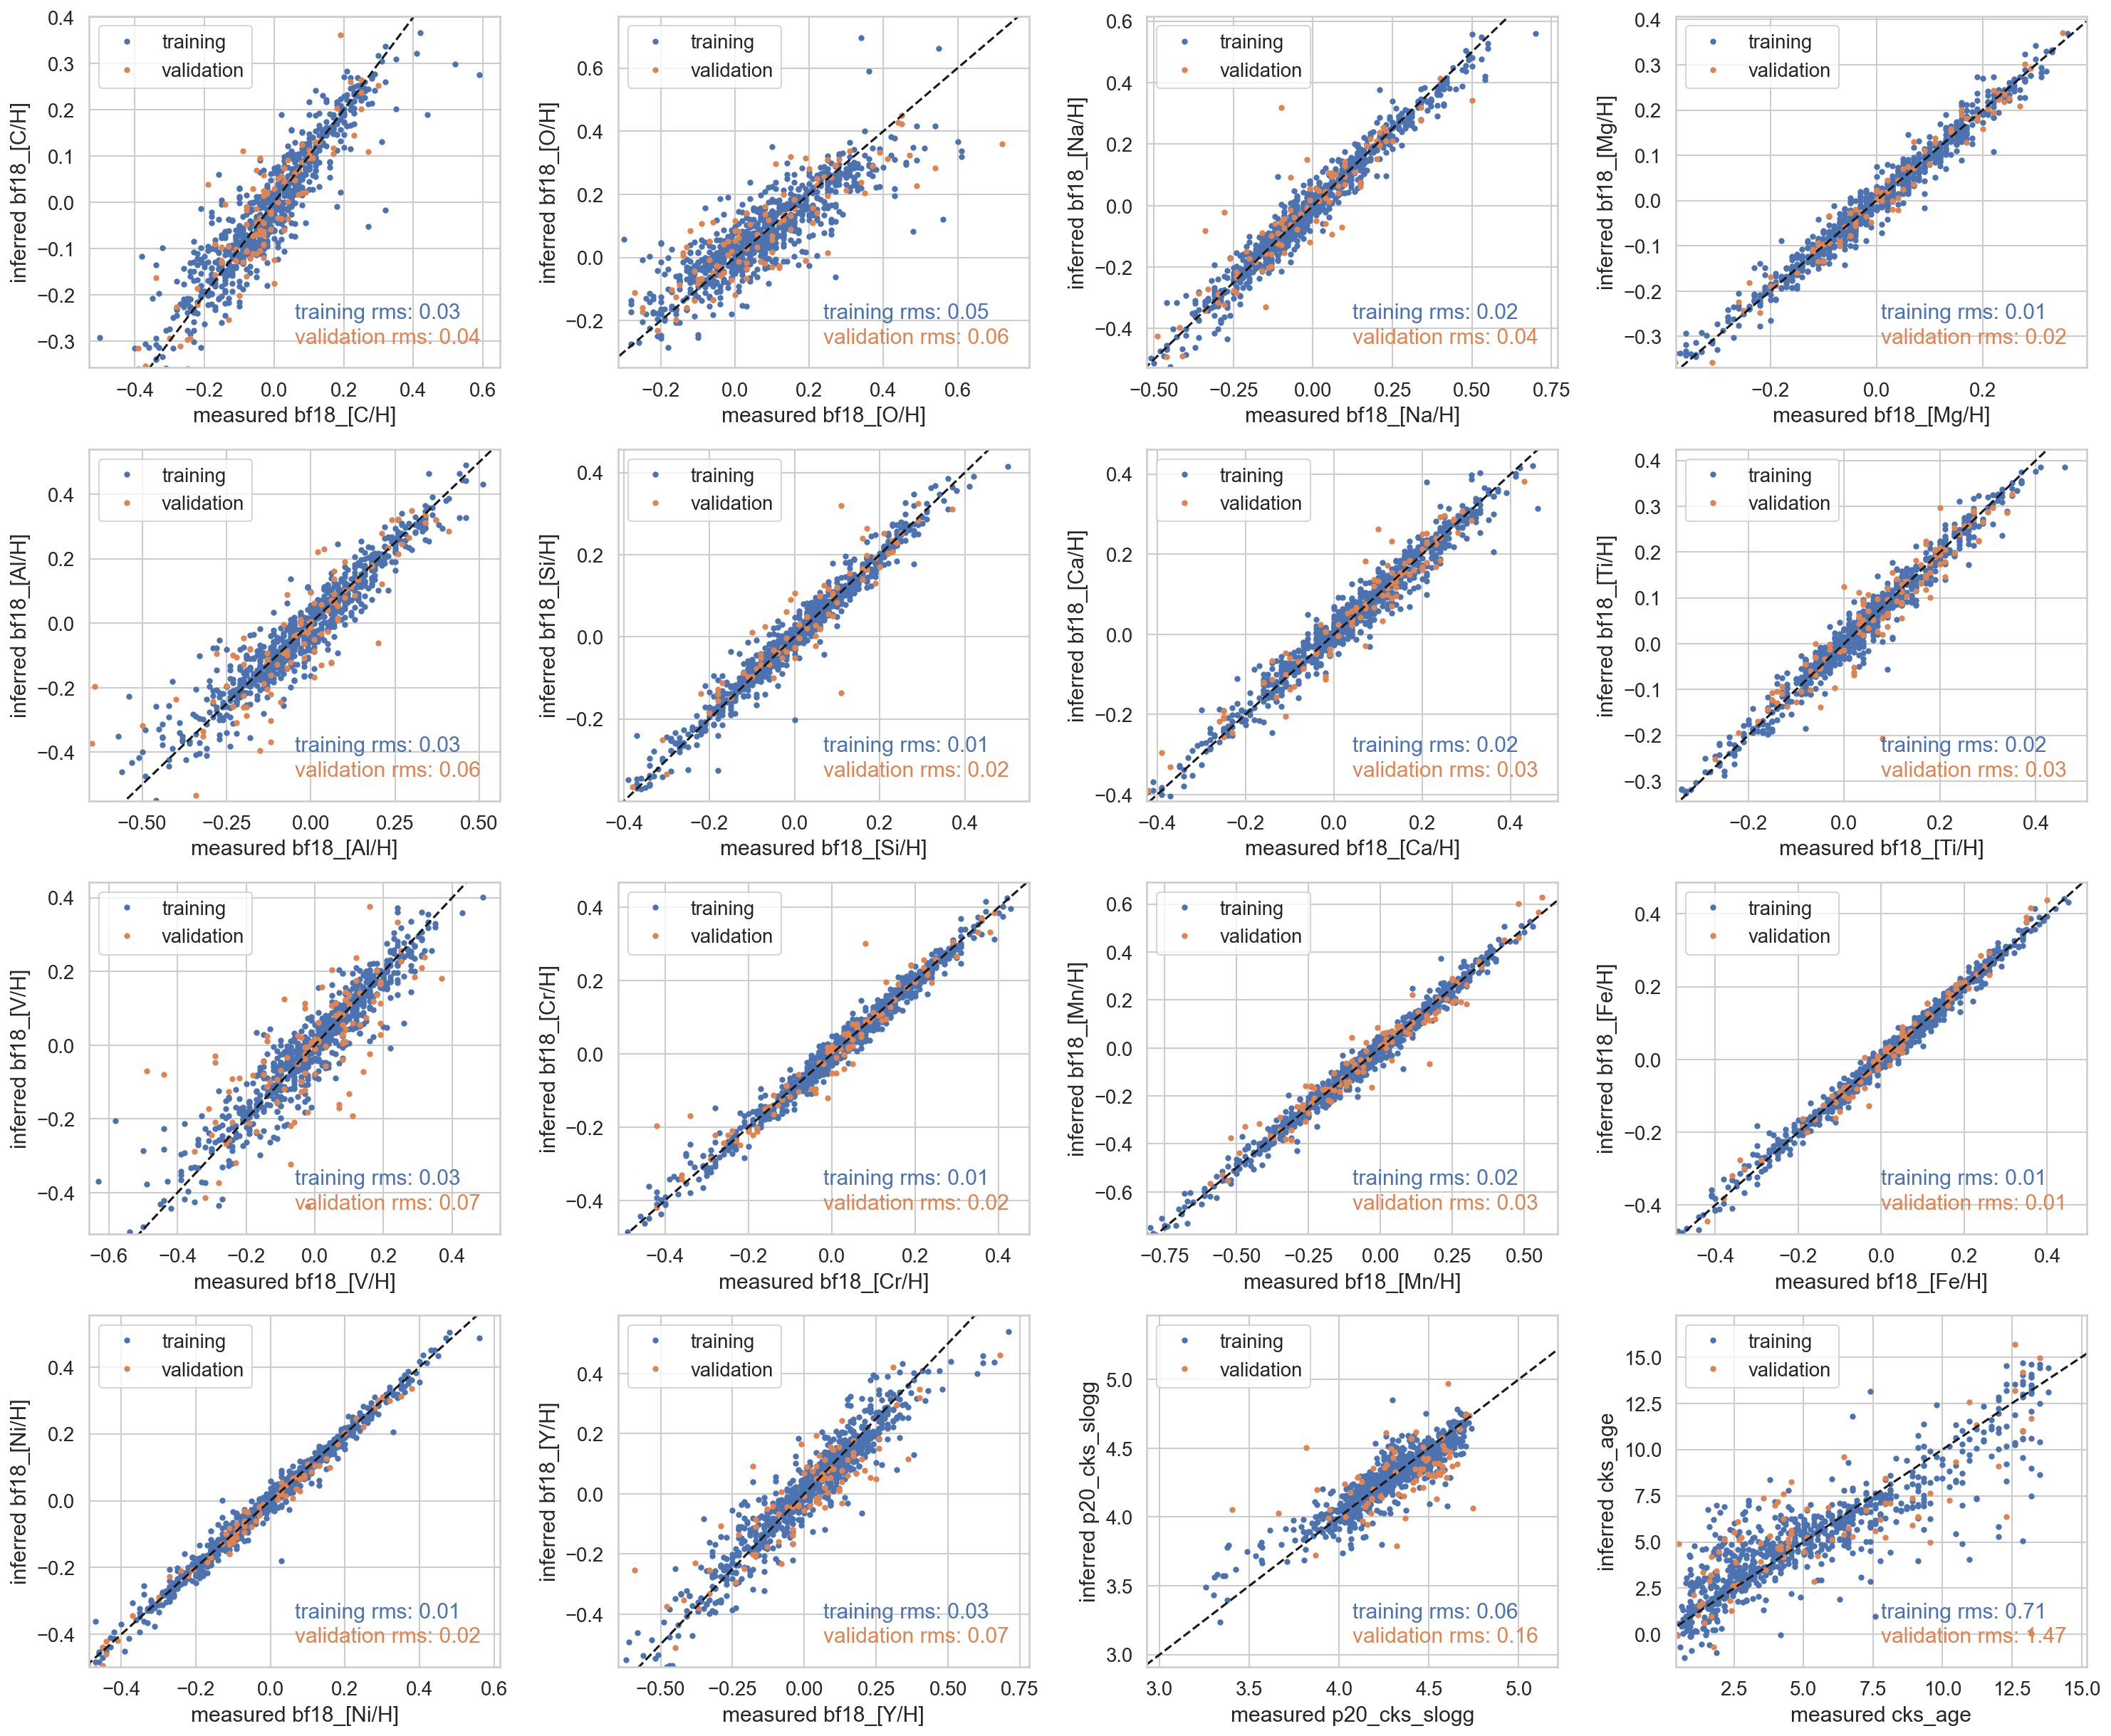

In [159]:
# What about the held out data
Y_mod = model(params)

plt.figure(figsize=(20,20))

for i in range(np.shape(Y)[1]):
    
    ax = plt.subplot(5, 4, i+1)
    
    m = validate_mask[:, i]
    
    _x = Y[:, i]*emp_sigma[i] + emp_mu[i]  
    _y = Y_mod[:, i]*emp_sigma[i] + emp_mu[i]
    
    # plt.plot(Y_mod[m, i]*emp_sigma[i] + emp_mu[i], 
    #         Y[m, i]*emp_sigma[i] + emp_mu[i], ".", label="validation")  

    plt.plot(_x[~m], _y[~m], ".", label="training")
    plt.plot(_x[m], _y[m], ".", label="validation")  

    train_rms = np.sqrt(np.median((_x[~m]-_y[~m])**2))
    valid_rms = np.sqrt(np.median((_x[m]-_y[m])**2))

    plt.text(0.5, 0.14, 'training rms: '+"{:.2f}".format(train_rms), transform=ax.transAxes, color='C0')
    plt.text(0.5, 0.07, 'validation rms: '+"{:.2f}".format(valid_rms), transform=ax.transAxes, color='C1')

    xmin,xmax = 0.9*np.min(_x), 1.1*np.max(_x)
    ymin,ymax = 0.9*np.min(_y), 1.1*np.max(_y)

    plt.plot([-100,100],[-100,100], 'k--')
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)

    plt.legend(loc='upper left')
    plt.xlabel(f"measured {df.columns[i]}")
    plt.ylabel(f"inferred {df.columns[i]}")

plt.tight_layout();

# Introduction to the latent variable model

(based on Chapter 29 of "Probabilistic Machine Learning" by Kevin Murphy)

A latent variable model is a statistical model that relates observable (or "manifest") variables ($\textbf{x}$) to a set of latent variables ($\textbf{z}$).

$$\textbf{z} \sim p(\textbf{z})$$

$$\textbf{x}|\textbf{z} \sim \text{Expfam}(\textbf{x}|f(\textbf{z}))$$

where $f(\textbf{z})$ is known as the *decoder*, and $p(\textbf{z})$ is some kind of prior. 

We assume that $\textbf{z}$ is a single “layer” of hidden random variables, corresponding to a set of “latent factors”. In a Gaussian Process Latent Variable Model (GPLVM), the decoder $f$ is assumed to be a Gaussian process.

In [160]:
try:
    import tinygp
except ImportError:
    %pip install -q tinygp
    import tinygp
    
try:
    import jaxopt
except ImportError:
    %pip install -q jaxopt
    import jaxopt

In [161]:
from tinygp import kernels, transforms, GaussianProcess

import jax
import jax.numpy as jnp

jax.config.update("jax_enable_x64", True)

## Gaussian Process Latent Variable Model (GPLVM)

Based on the tinygp documentation:
https://tinygp.readthedocs.io/en/latest/tutorials.html

In [163]:
# X should be U (latent rep of data)
# Gp wants zero mean
# do we want to fit a different mean for each column
# how to handle different scale, amplitude for each column

def build_1gp(U, params, yerr):
    
    #10/19/2022 coded up with DFM
    #This defines the model for a single column
    #U is the latent representation of the data matrix
    
    #log_gp_amp: scalar, should have the units of data, different for each column
    #log_gp_scale has units of U - distance between latent representation
    #log_gp_scale - one for each latent dim, might introduce covariances in    
    #how smooth is that column in latent dim 0,1,etc.
    #think of U as the time coordinate
    #start with scalar for scale, eventually latent dim
    #diag is where you'd include error on data. yerr**2 + jitter term
    
    #transform is about handling distance in higher dims
    #Matern52 was returning inf, expsquared uses squared distance behind the scenes, seems to work
    
    kernel = jnp.exp(params["log_gp_amp"]) * transforms.Linear(
        jnp.exp(-params["log_gp_scale"]), kernels.ExpSquared()
    )
    
    return GaussianProcess(kernel, 
                           U, 
                           diag=jnp.exp(params["log_gp_diag"])+yerr**2,
                           mean=params["mean"])

@jax.jit
def loss1(U,params,y,yerr):
    #Returns the loss for a single column of the data
    gp = build_1gp(U,params,yerr)
    return -gp.log_probability(y)


#Note data matrix has already been normalized
init_params = {"log_gp_amp": np.log(np.var(Y[:,0])),
               "log_gp_scale": np.zeros(latent_dim),
               "log_gp_diag": np.log(np.min(err[:,0])),
               "mean": np.mean(Y[:,0])}


#Check to see if the loss function returns a reasonable value:
loss1(params["U"], init_params, Y[:,0], err[:,0])

DeviceArray(724.74184252, dtype=float64)

In [164]:
from functools import partial

@jax.jit
def loss_full(params):
    ll = jax.vmap(partial(loss1, params["U"]))(params["gp"], Y.T, err.T)
    return jnp.sum(ll, axis=0)

full_init_params = {
    "U": params["U"],
    "gp": {
        "log_gp_amp": np.log(np.var(Y, axis=0)),
        "log_gp_scale": np.zeros((Y.shape[1], latent_dim)),
        "log_gp_diag": np.log(np.min(err, axis=0)),
        "mean": np.mean(Y, axis=0)
    }
}
jax.value_and_grad(loss_full)(full_init_params)

#With GP, when you predict data you get new GP, and that's the likelihood we want

(DeviceArray(8577.54668475, dtype=float64),
 {'U': DeviceArray([[  0.86568907,  -0.37512589,   0.7239814 ,   3.40824431,
                  0.27046101],
               [ -0.20287883,   0.36195522,  -0.07325261,  -1.99579183,
                 -1.83021301],
               [  1.85634077,  -1.76131585,  -2.43080935,   2.94750382,
                 -6.08119884],
               ...,
               [  7.15008643,  13.29472022,   6.47505077,  -8.66845569,
                 12.6689313 ],
               [ -0.21089455,  -1.59110244,  -1.86241098,   4.25008842,
                  6.37279909],
               [  0.72044059, -10.16883632,   0.52601656,   0.68269069,
                 -1.90050325]], dtype=float64),
  'gp': {'log_gp_amp': DeviceArray([ 67.13706449,  51.94389488, 128.86185933, 130.09510218,
                 73.95298956, 118.87158961, 119.41599801, 119.94319664,
                 66.63918772, 133.46002858, 129.42688097, 143.74108364,
                149.00040234,  74.19028609,  51.58703964,  8

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [23:42<00:00,  1.42s/it]


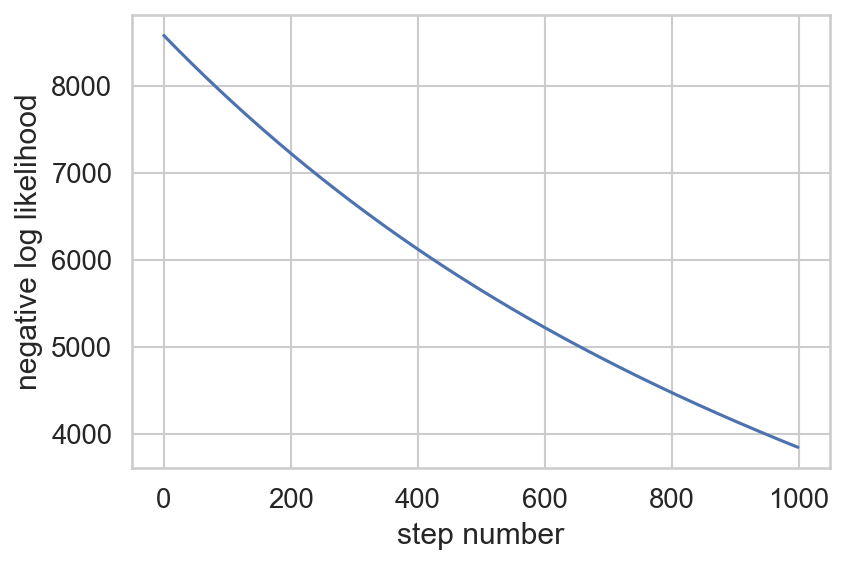

In [167]:
#Train on just the training stars. Next step involves predictions for held out.
import optax
from tqdm import trange

learning_rate = 3e-4

full_params = full_init_params

tx = optax.adam(learning_rate=learning_rate)
opt_state = tx.init(full_params)

@jax.jit
def step(params, opt_state):
    loss_val, grads = jax.value_and_grad(loss_full)(params)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return loss_val, params, opt_state

losses = []

for i in trange(1_000):
    loss_val, full_params, opt_state = step(full_params, opt_state)
    losses.append(loss_val)

plt.plot(losses)
plt.ylabel("negative log likelihood")
_ = plt.xlabel("step number")

# Plot projections of the latent representation

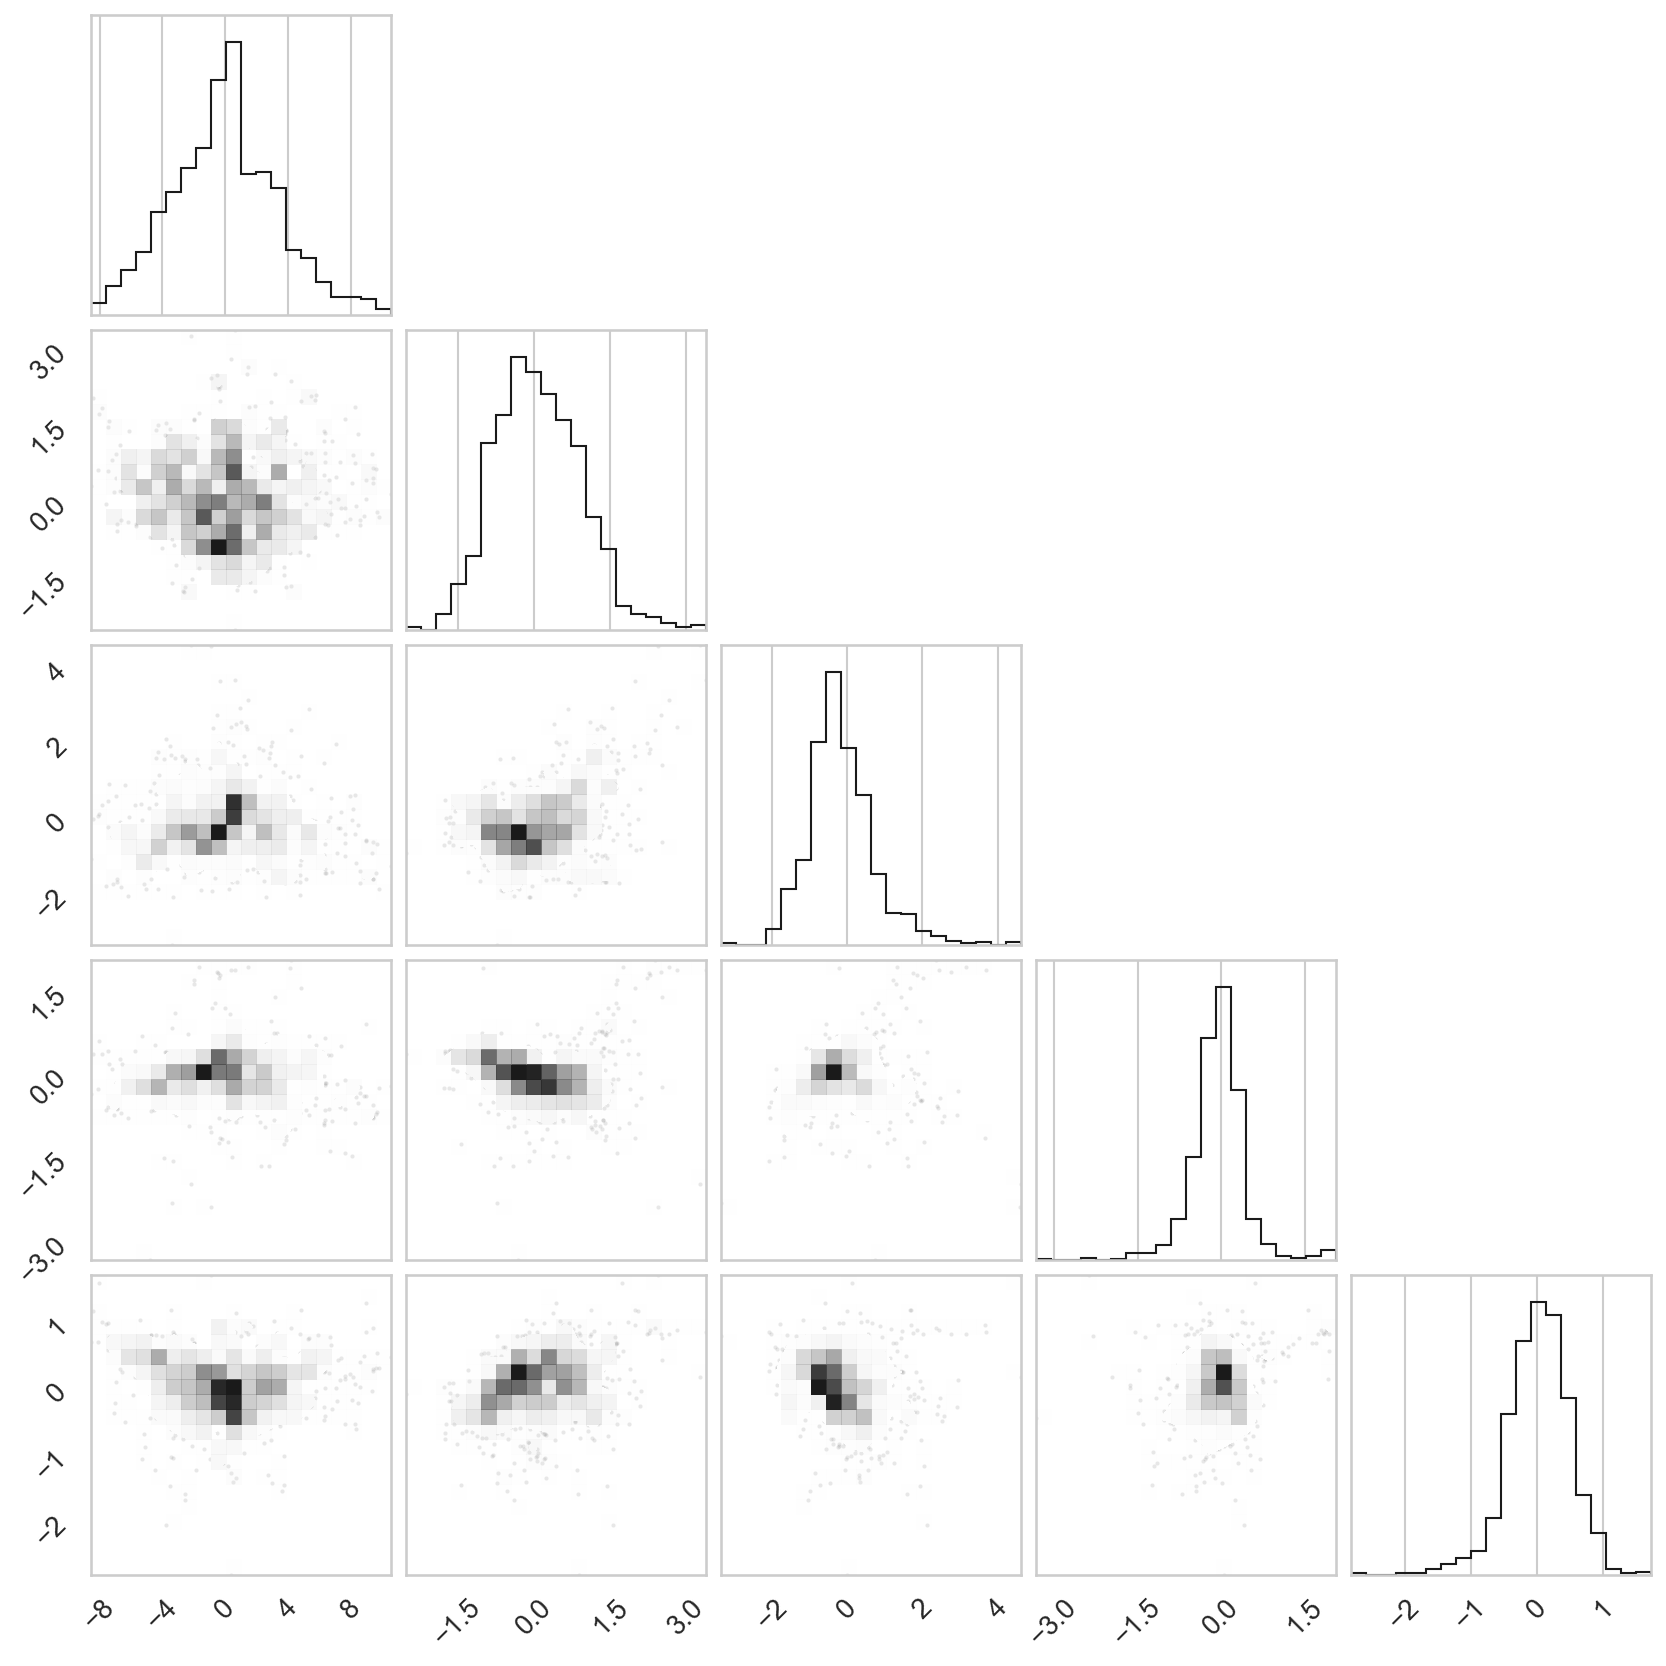

In [186]:
import corner

_U = np.array(full_params["U"])

figure = corner.corner(_U, plot_contours=False)

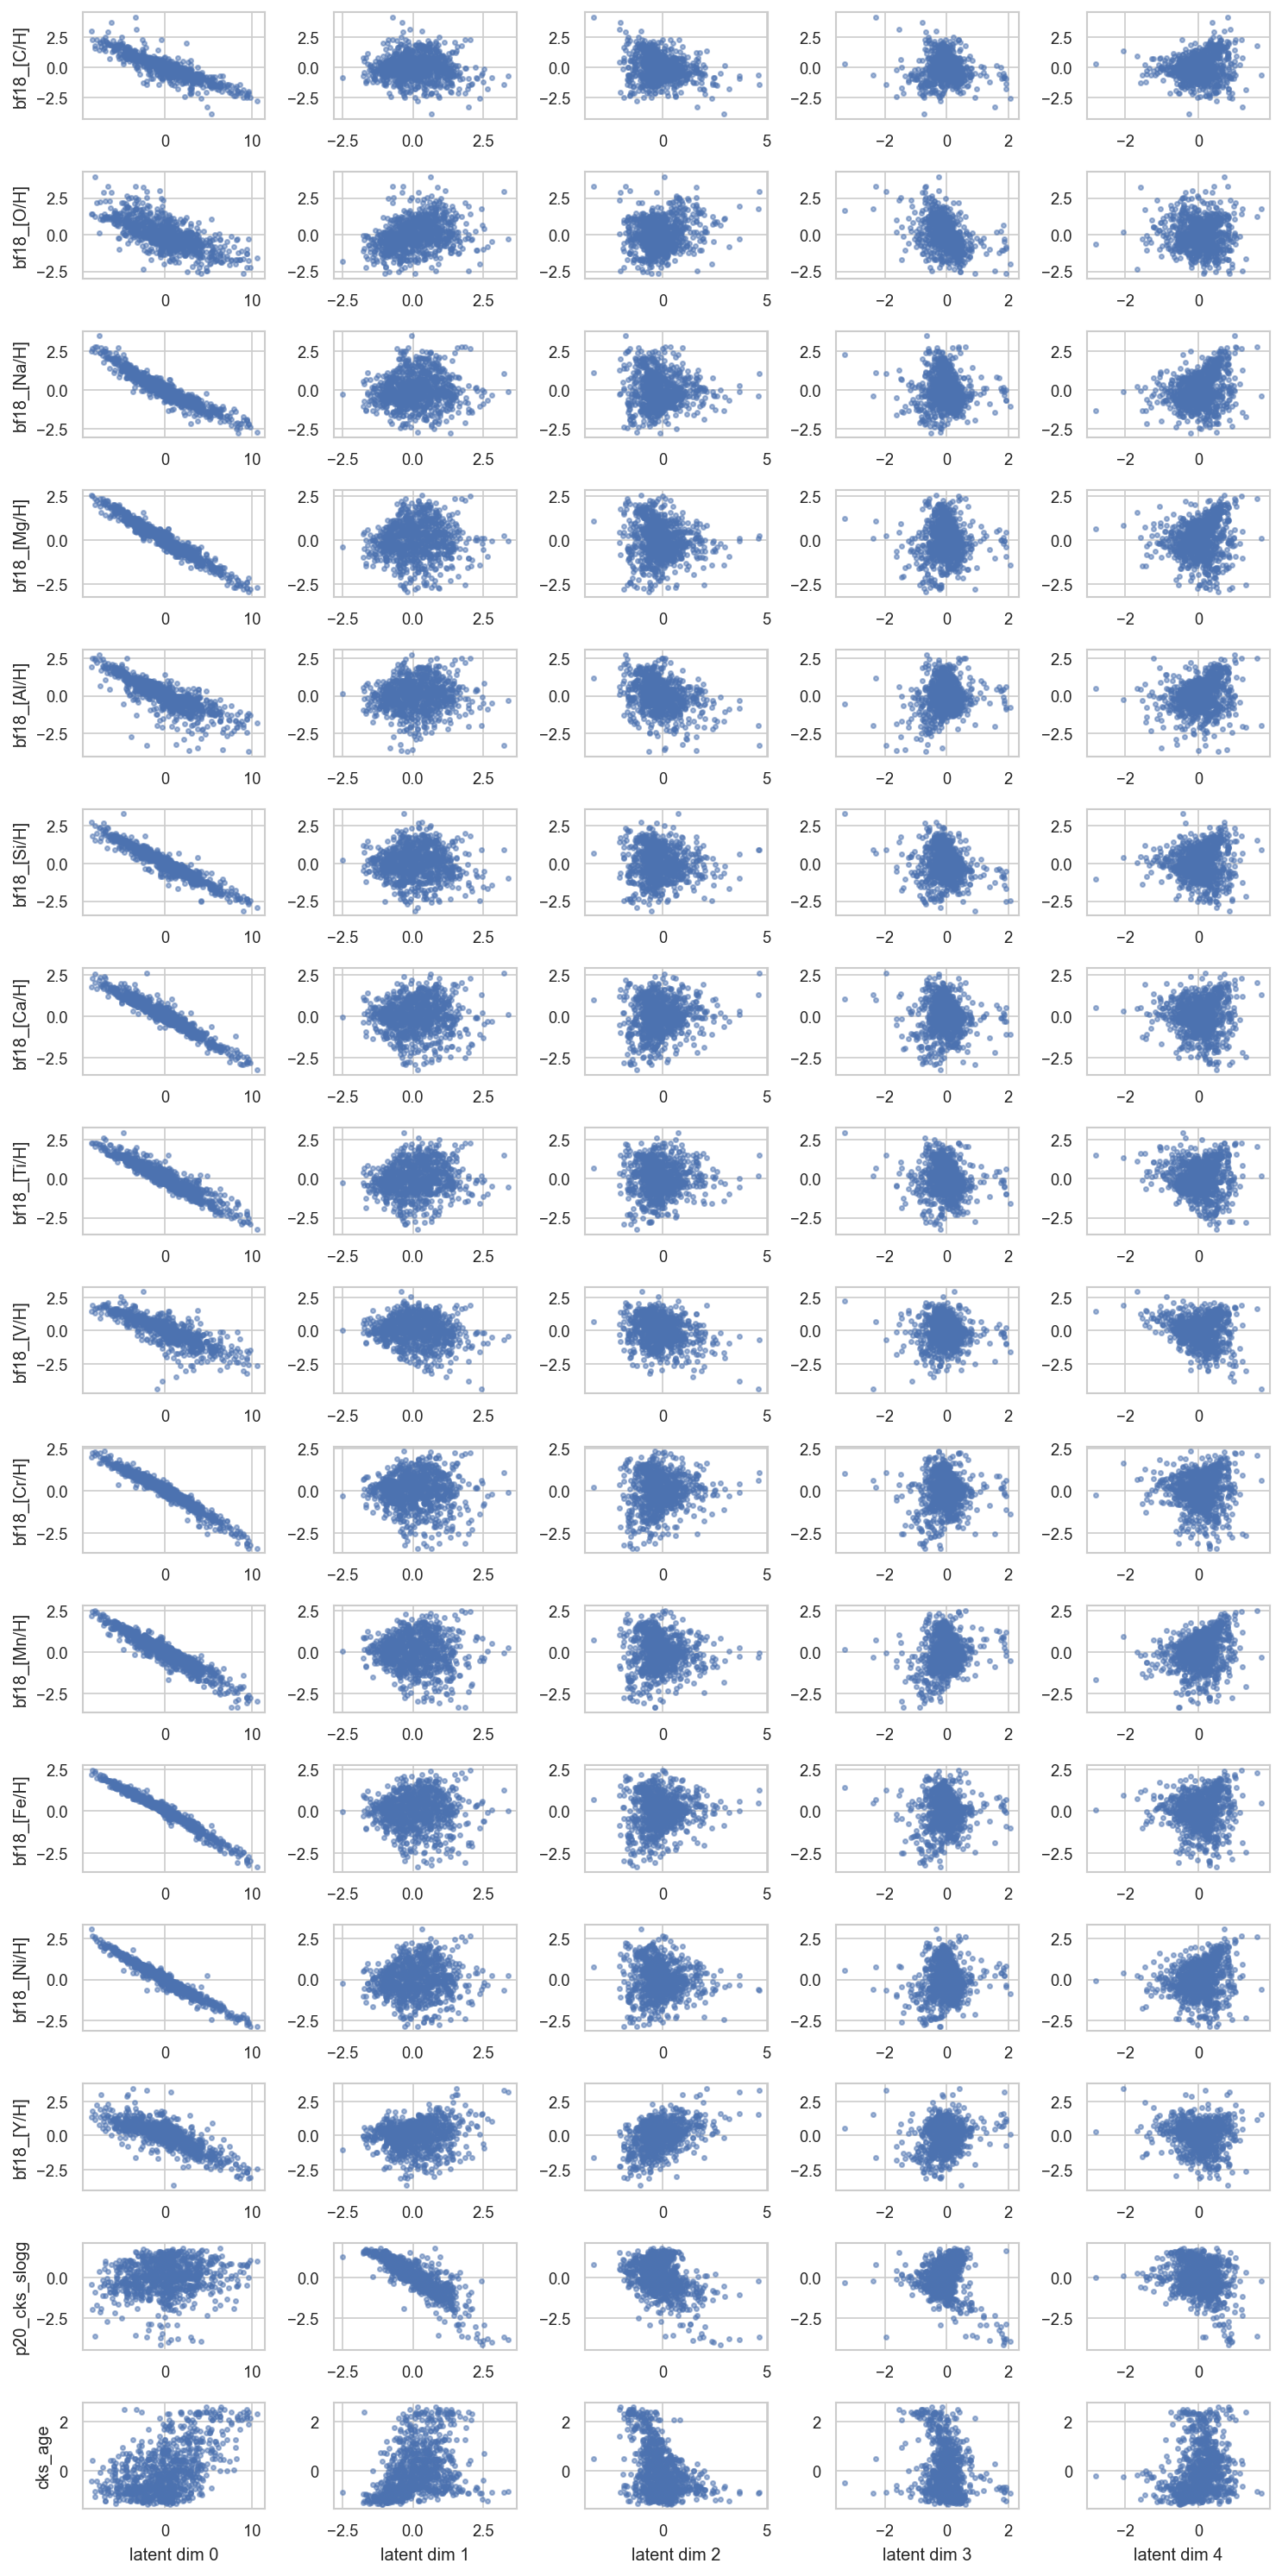

In [196]:
sns.set_context("paper")

obs_dim = Y.shape[1]

fig, axes = plt.subplots(nrows=obs_dim,
                       ncols=latent_dim,
                       figsize=(10,20))

for i in range(obs_dim):
    for j in range(latent_dim):
        
        ax = axes[i,j]
        ax.plot(full_params["U"][:, j], Y[:, i], '.', alpha=0.5)
        
        if j==0:
            ax.set_ylabel(df.columns[i])
            
        if i==obs_dim-1:
            ax.set_xlabel("latent dim "+str(j))
        
plt.tight_layout()
plt.show()

Initial impression based on the plot above is that the GPLVM is doing a better job at isolating logg

In [125]:
# prediction/held out data
# fn that predicts mean
# params are fixed - after optimization

def predict_one_column_of_new_star(U_test, 
                                   U_train, 
                                   params_train, 
                                   y_train, 
                                   yerr_train):
    gp = build_1gp(U_train, params_train, yerr_train)
    cond_gp = gp.condition(y_train, X_test=U_test[None, :]).gp
    return cond_gp.loc[0], cond_gp.variance[0]

def predict_new_star(U_test, 
                     U_train, 
                     params_train, 
                     y_train, 
                     yerr_train):
    
    return jax.vmap(partial(predict_one_column_of_new_star, U_test, U_train))(params_train, y_train.T, yerr_train.T)

@jax.jit
def loss_new_star(U_test,
                  U_train,
                  params_train,
                  y_train,
                  yerr_train,
                  y_test,
                  yerr_test,
                  mask_test):
    
    mu, var = predict_new_star(U_test, U_train, params_train, y_train, yerr_train)
    var += yerr_test**2
    
    return jnp.sum((0.5 * (y_test - mu)**2 / var + 0.5 * jnp.log(var)) * mask_test)

#We may be able to speed up loss_new_star

mask = np.ones(16, dtype=bool)
mask[-1] = False

# Could test how good age predictions are as you hold out different columns

loss_new_star(np.zeros(latent_dim), full_init_params["U"], full_init_params["gp"], Y, err, np.zeros(16), 0.1*np.ones(16), mask
)

#Optimize loss above for some value of held out data --> prediction of latent rep for held out data
#Latent rep prediction --> predict_new_star: will predict observables given held out latent rep
#Look at tutorial for jaxopt - better for low dim optimization

#mask would be e.g. the column left out for one star
#need to see some data for every star
#for each new star, run a nonlinear opt to find U_test - its simpler bc GP is fixed, 


DeviceArray(-10.01687291, dtype=float64)

### How to hold out data?
-Train GP model first with some stars removed, then fix GP model
-Given the training data and fixed hyperparameters, you can predict what the U should be for that star

1) Predict held out columns
2) Fix everything, optimize for U, then use that U predict for held out star